In [7]:
%load_ext autoreload
%autoreload 2

import sys
import pickle 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

sys.path.append('../')

from actx import CaseCI, LimeReport, ShapReport, DiCeReport, Comparator

pd.set_option('display.max_columns', 500)

import tensorflow as tf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Get a model

In [8]:
case = CaseCI()

In [9]:
%%capture --no-display
case.train_model()

In [10]:
case.save_pipe(1, 'case_mean_imp')

 ROC AUC train :  0.6738824367934839 
 ROC AUC val :  0.6408452273092748 
 ROC AUC test :  0.6412330366802789 

Precision test :  0.8477747144545097
Recall test :  0.7040641099026903
F-1 test :  0.7692651329014966


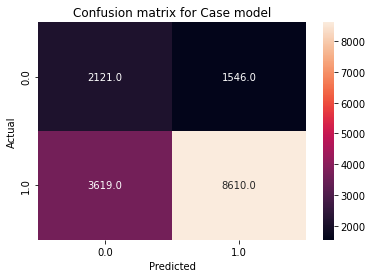

Predicted   0.0   1.0
Actual               
0.0        2121  1546
1.0        3619  8610


In [11]:
case.print_metrics()

In [12]:
with open(f'../models/case.pkl', 'wb') as f:
    pickle.dump(case, f)
    
with open(f'../models/case.pkl', 'rb') as f:
    case = pickle.load(f)

## Dataset 

In [6]:
case.data.shape

(76636, 87)

In [7]:
case.data.head()

,F_0,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,F_9,F_10,F_11,F_12,F_13,F_14,F_15,F_16,F_17,F_18,F_19,F_20,F_21,F_22,F_23,F_24,F_25,F_26,F_27,F_28,F_29,F_30,F_31,F_32,F_33,F_34,F_35,F_36,F_37,F_38,F_39,F_40,F_41,F_42,F_43,F_44,F_45,F_46,F_47,F_48,F_49,F_50,F_51,F_52,F_53,F_54,F_55,F_56,F_57,F_58,F_59,F_60,F_61,F_62,F_63,F_64,F_65,F_66,F_67,F_68,F_69,F_70,F_71,F_72,F_73,F_74,F_75,F_76,F_77,F_78,F_79,F_80,F_81,F_82,F_83,F_84,target,train_flag
0,0.0,1.0,0.148125,0.12,0.250000,0.019608,0.75,0.750000,0.008264,0.214286,0.0,0.157895,0.771429,0.190110,0.403239,0.123077,0.000000,0.436173,0.130890,0.04,0.118280,0.207464,0.219512,0.000000,0.025385,0.0,0.153333,0.25,0.0,0.045517,0.000000,1.0,0.27,0.000000,0.000000,0.000000,0.028446,0.67,0.003722,0.021081,0.365854,0.107143,0.027559,0.136027,0.058824,0.189509,0.434938,0.044199,0.066719,0.013793,0.000000,0.266667,0.250,0.733333,0.118812,0.000000,0.534915,1.0,0.000000,0.103954,0.000000,0.08,0.400571,0.034188,0.0,0.348837,0.000000,1.0,0.378709,0.471278,0.00000,0.049689,0.041731,0.508301,0.000000,0.000000,0.0,0.651163,0.00,0.063875,0.000000,0.000000,0.000000,0.0,0.662129,1.0,1
1,0.2,1.0,0.088814,0.00,0.428571,0.000000,1.00,0.571429,0.161157,0.571429,0.0,0.315789,0.592593,0.381684,0.053849,0.169231,0.000000,0.856015,0.193717,0.24,0.215054,0.350465,0.414634,0.000000,0.076923,0.0,0.325022,0.41,0.0,0.121378,0.000000,1.0,0.83,0.000000,0.000000,0.000000,0.181619,0.44,0.011278,0.032925,0.512195,0.678571,0.192913,0.060289,0.107843,0.245347,0.210203,0.154696,0.545538,0.059120,0.000000,0.743590,0.250,0.256410,0.742574,0.454545,0.441253,1.0,0.000000,0.078556,0.000000,0.08,0.488359,0.495726,0.0,0.709419,0.000000,1.0,0.269102,0.471278,0.00000,0.037267,0.024730,0.298106,0.000000,0.000000,0.0,0.290581,0.25,0.040619,0.000000,0.235294,0.157303,0.0,0.662129,1.0,1
2,0.0,1.0,0.338045,0.28,0.826087,0.019608,0.00,0.173913,0.020661,0.142857,0.0,0.368421,0.727273,0.551532,0.028223,0.092308,0.000000,0.662558,0.099476,0.38,0.193548,0.479643,0.487805,0.000000,0.051538,0.0,0.265455,0.75,0.0,0.121378,0.004751,1.0,0.52,0.000000,0.006623,0.000000,0.146608,0.25,0.007556,0.063520,0.207317,0.357143,0.031496,0.055478,0.039216,0.324873,0.357704,0.127072,0.133438,0.072864,0.000000,0.512821,0.000,0.461538,0.356436,1.000000,0.673727,1.0,0.000000,0.057089,0.000000,0.00,0.285102,0.170940,0.0,0.539192,0.025641,1.0,0.269628,0.545354,0.00000,0.029503,0.024730,0.377483,0.000000,0.000000,0.0,0.456057,0.00,0.040776,0.000000,0.000000,0.000000,0.0,0.662129,0.0,1
3,0.2,1.0,0.291026,0.00,0.714286,0.019608,1.00,0.285714,0.000000,0.071429,0.0,0.105263,1.000000,0.181186,0.054456,0.000000,0.333333,0.931291,0.125654,0.10,0.064516,0.258796,0.317073,0.230068,0.025385,0.0,0.213333,1.00,0.0,0.091033,0.000000,1.0,0.18,0.000000,0.000000,0.191675,0.218818,0.00,0.007556,0.000000,0.182927,0.035714,0.003937,0.001774,0.019608,0.035533,0.011633,0.038674,0.029119,0.064447,0.278273,0.250000,0.000,0.750000,0.049505,0.000000,0.000000,1.0,0.007808,0.029098,0.664415,0.00,0.000000,0.017094,0.0,0.487805,0.000000,1.0,0.000000,0.471278,0.23049,0.063665,0.068006,0.023635,0.728987,0.094765,0.0,0.512195,0.00,0.000000,0.572306,0.000000,0.000000,0.0,0.662129,1.0,1
4,0.2,1.0,0.112170,0.00,0.000000,0.019608,0.25,0.000000,0.004132,0.000000,0.0,0.157895,0.966667,0.265745,0.029672,0.015385,0.000000,0.423228,0.219895,0.00,0.118280,0.228198,0.292683,0.000000,0.076923,0.0,0.266667,0.80,1.0,0.106205,0.086687,1.0,0.08,0.027778,0.092715,0.000000,0.282276,0.20,0.026277,0.005722,0.548780,0.321429,0.000000,0.089758,0.000000,0.255499,0.566178,0.002762,0.167906,0.081196,0.000000,0.480000,0.375,0.440000,0.217822,0.000000,0.864041,1.0,0.000000,0.062542,0.000000,0.00,0.098104,0.102564,0.0,0.445820,0.080000,1.0,0.110432,0.471278,0.00000,0.041925,0.044822,0.557493,0.000000,0.000000,0.0,0.467492,0.25,0.044626,0.000000,0.000000,0.000000,0.0,0.662129,1.0,1


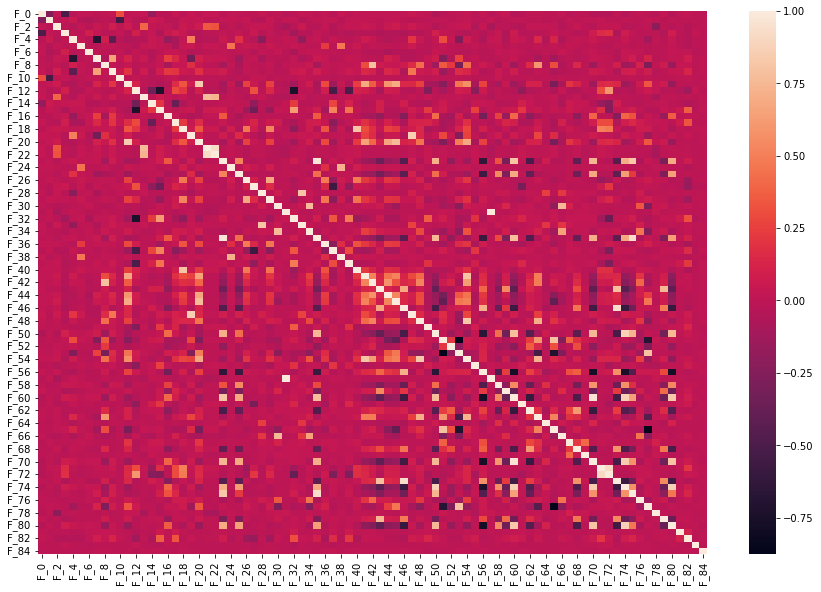

In [8]:
plt.subplots(figsize=(15, 10))
sns.heatmap(case.data.drop(columns=['target','train_flag']).corr());
# plt.title('Correlations between features in a Bank Marketing Dataset');

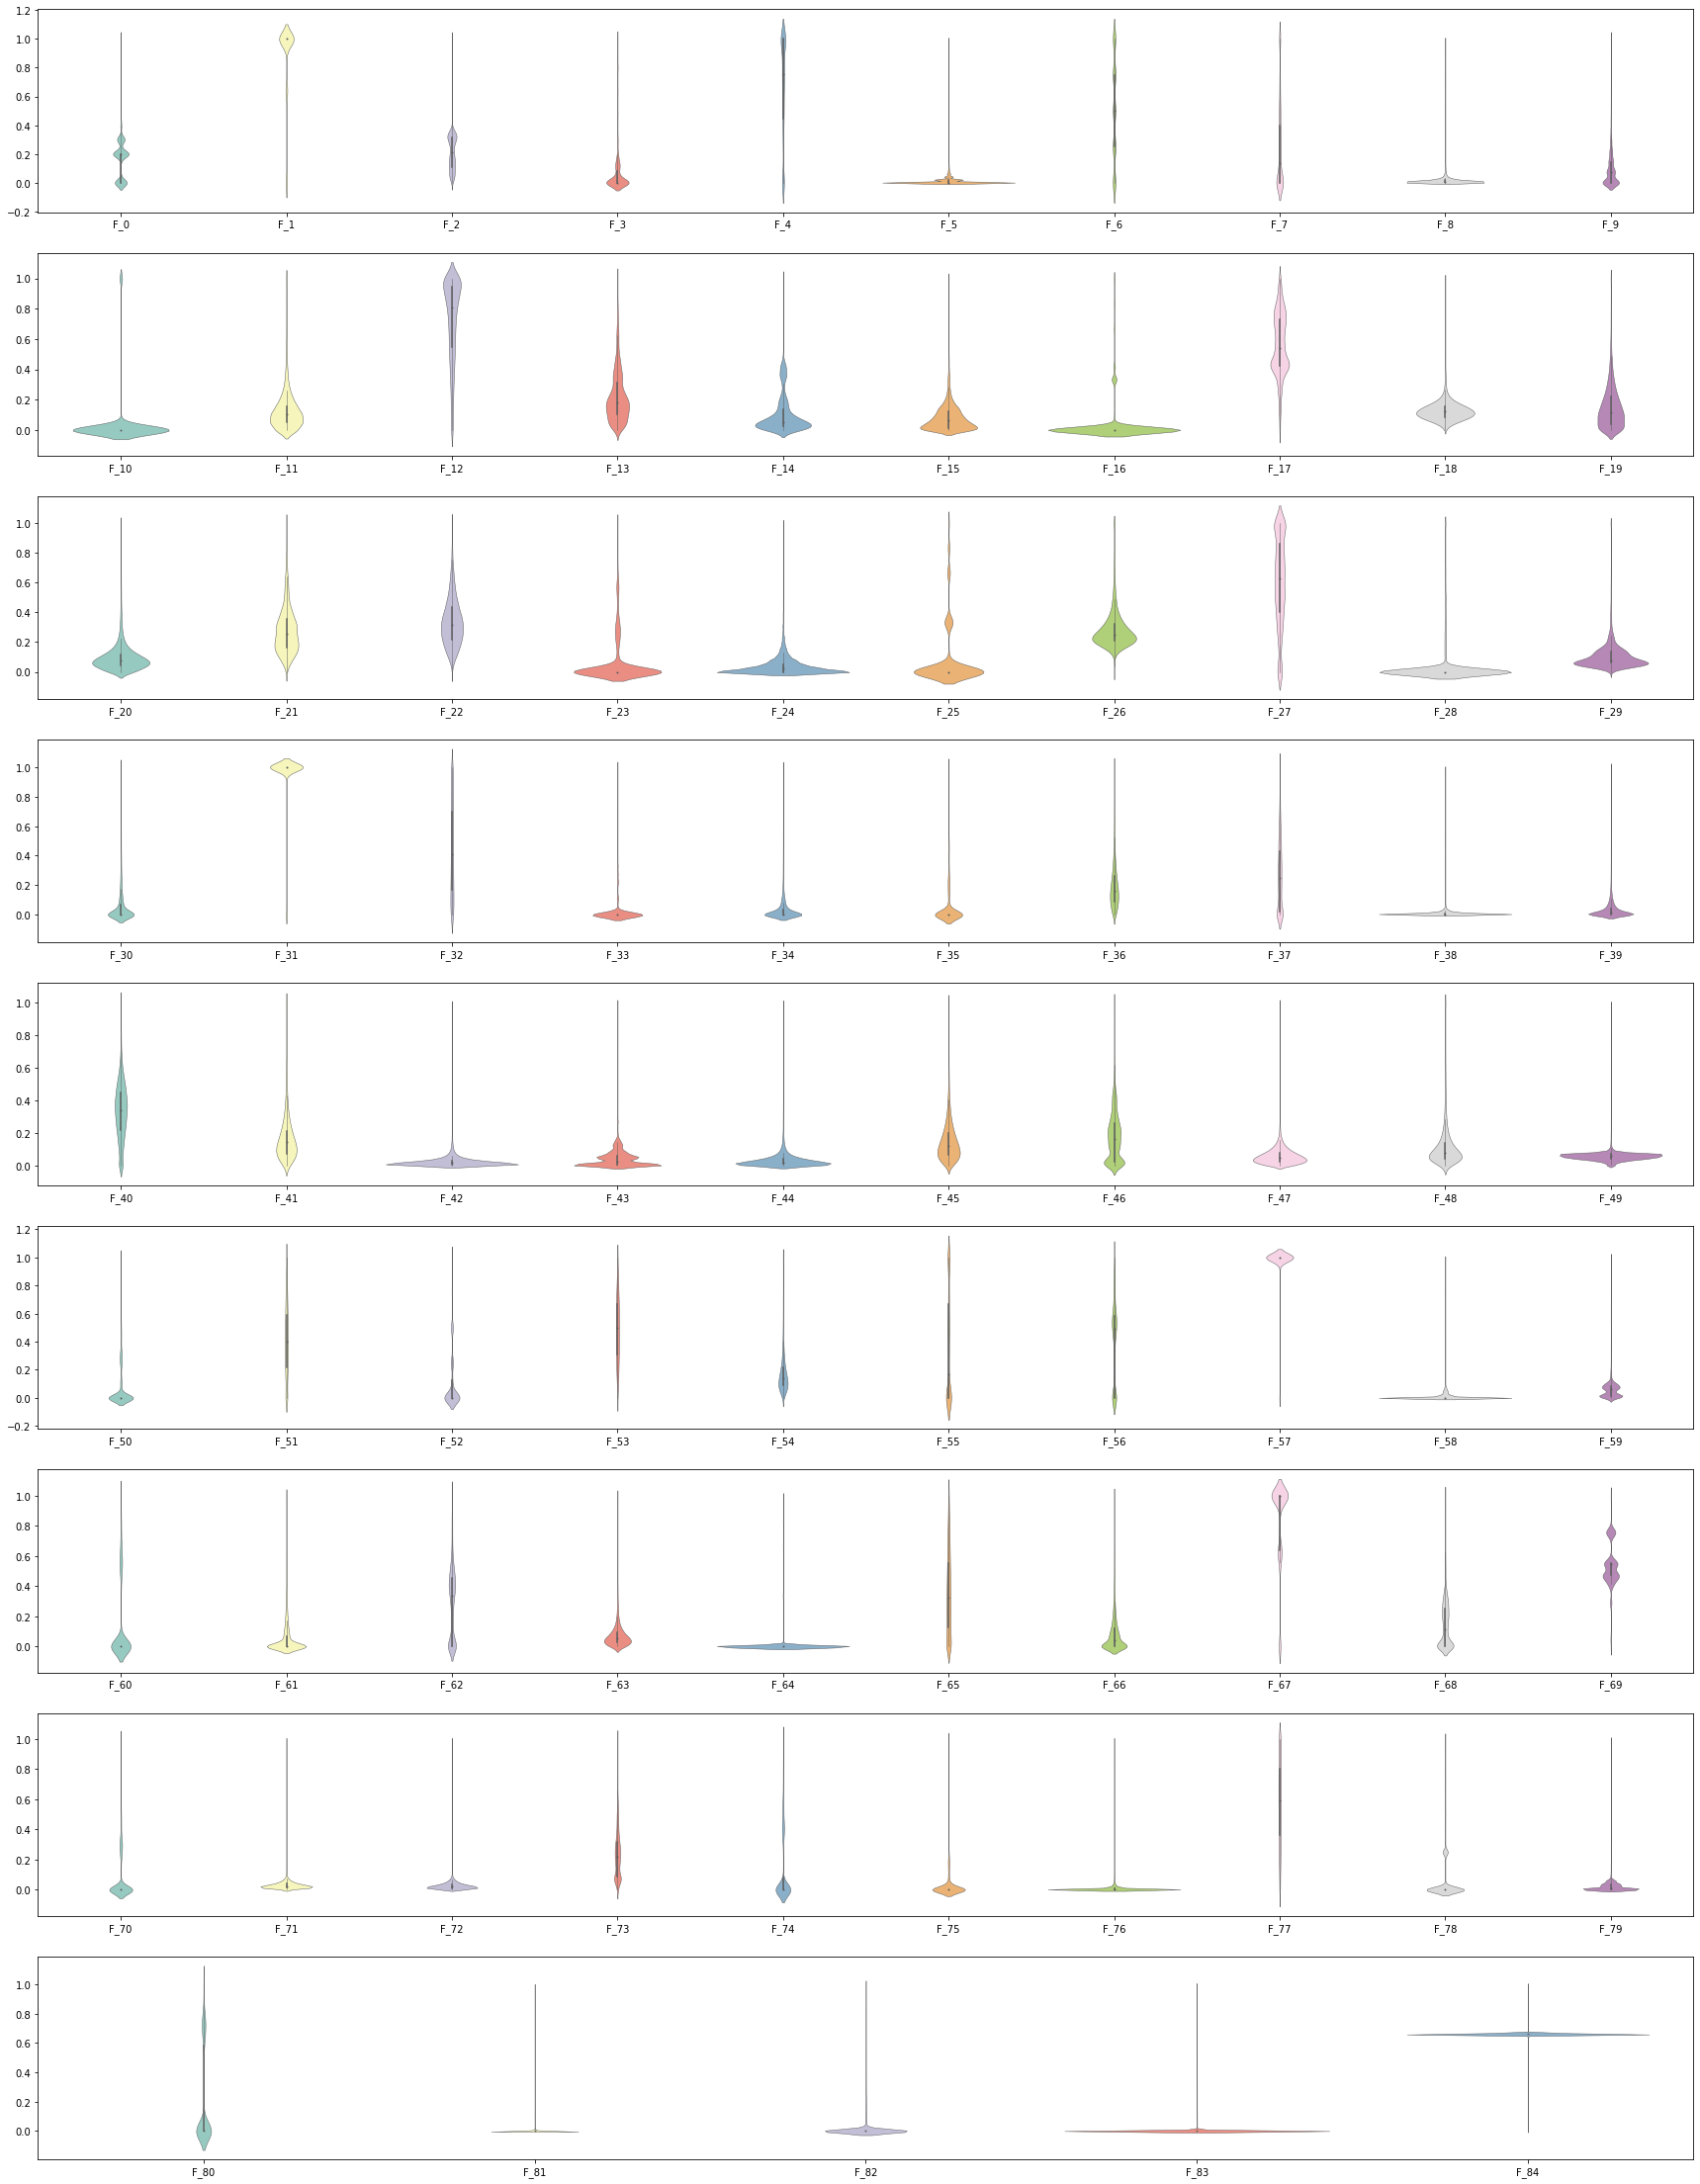

In [9]:
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]
        
names = case.names
fig, ax = plt.subplots(len(list(chunks(names,10))), 1, figsize=(30,40))
for i, s in enumerate(list(chunks(names,10))):
    df = case.data.drop(columns=['train_flag']).loc[:,s]
    sns.violinplot(data=df, palette="Set3", bw=.2, linewidth=.5, ax=ax[i]);

In [10]:
1-case.data.target.mean()

0.22689075630252098

## Changeable features

1.	Общее количество сделок, заключенных с организацией на текущий день. С ростом количества открытых сделок на одного клиента вероятность отказа снижается на 10%. Формулировка задачи: «Проверь по своим клиентам соблюдение контактной политики. Старайся оперативно реагировать на потребности клиента». Выводим, если менее 5 открытых сделок на одного клиента
F_5 (PDP-plot)
2.	Доля завершенных звонков среди всех активностей за 3 дня. С ростом доли звонков среди всех активностей вероятность отказа растет на 1%. «Старайся поддерживать очный контакт с клиентами». Выводим, если более 0.9 доля звонков.
F_12 (PDP-plot)
3.	Среднее количество уникальных продуктов, предложенных клиенту за 3 дня. С ростом количества уникальных предложенных продуктов вероятность отказа растет на 2%. «Старайся точно идентифицировать потребности клиента и не предлагать новые продукты без необходимости». Выводим, если более 4 количество уникальных предложенных продуктов.
F_24 (PDP-plot)
4.	Количество уникальных продуктов, предложенных клиентам за 3 дня. С ростом числа уникальных предложенных продуктов у клиента вероятность отказа растет на 0.9%. «Старайся не предлагать большой ряд продуктов, уточни потребность клиента». Выводим, если более 15 уникальных предложенных клиентам продуктов.
F_18 (PDP-plot)
5.	Среднее количество завершенных встреч и завершенных звонков за 3 дня. Если совершать встречи, вероятность отказа снижается на 0.4%. «Старайся поддерживать очный контакт с клиентом». Выводим, если нет встреч и есть звонки за последние 3 дня.
F_15, F_72 (PDP-plot)



## DiCE Report

In [13]:
features_to_vary = ['F_12', 'F_24', 'F_18', 'F_15', 'F_72']

### Generate counterfactuals for all test data using only changeable features with custom range

In [14]:
dice = DiCeReport(case, desired_class=0, 
                  features_to_vary=features_to_vary, 
                  custom_range=True)
dice.create_explainer(method='random')

{'F_12': [0.166666665, 1.0], 'F_24': [0.0, 0.1538461538461538], 'F_18': [0.0418848167539266, 0.225130890052356], 'F_15': [0.0, 0.2307692307337278], 'F_72': [0.0030911901235998, 0.0649149922710214]}


In [15]:
%%capture --no-display
dice.evaluate_dataset(n=1, save=True, 
                      name='case_dice_custom')

  0%|          | 0/10156 [00:00<?, ?it/s]

In [16]:
dice.print_metrics()

63.89% of predicted instances of undesired class in the dataset
10156 predicted instances of undesired class analyzed
0.99% of successfull explanations, 101 instances
3.16% of programming package errors
95.84% of cases, where no CFs could be found by DiCE
0.31% of additional potential successes (model quality adjusted)
31 additional potential successes (model quality adjusted)
101 instances with recommended actions (extrapolated to the whole dataset)
31 additional successes in a test set  (model quality adjusted)

In 80.4% cases 2 features were changed
In 10.69% cases 1 features were changed
In 6.93% cases 3 features were changed
In 1.98% cases 4 features were changed

In 28.000000000000004% cases ['F_18' 'F_24'] features were changed
In 18.0% cases ['F_24' 'F_72'] features were changed
In 9.0% cases ['F_12' 'F_18'] features were changed
In 7.000000000000001% cases ['F_18'] features were changed
In 4.0% cases ['F_12' 'F_72'] features were changed
In 4.0% cases ['F_15' 'F_72'] features 

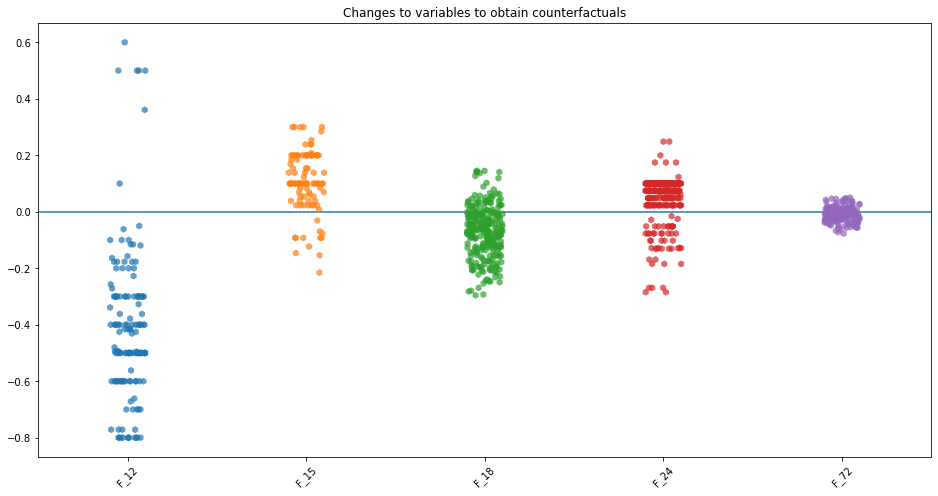

In [17]:
dice.plot_diffs(x=16, y=8, size=7)

In [18]:
with open(f'../models/case_dice_custom.pkl', 'wb') as f:
    pickle.dump(dice, f)
    
with open(f'../models/case_dice_custom.pkl', 'rb') as f:
    dice = pickle.load(f)

### Generate counterfactuals for all test data using only changeable features without custom range

In [25]:
dice2 = DiCeReport(case, desired_class=0, 
                  features_to_vary=features_to_vary, 
                  custom_range=False)
dice2.create_explainer(method='random')

None


In [26]:
%%capture --no-display
dice2.evaluate_dataset(n=1, save=True, 
                      name='case_dice_default')

  0%|          | 0/10156 [00:00<?, ?it/s]

In [27]:
dice2.print_metrics()

63.89% of predicted instances of undesired class in the dataset
10156 predicted instances of undesired class analyzed
1.14% of successfull explanations, 116 instances
3.7% of programming package errors
95.16% of cases, where no CFs could be found by DiCE
0.34% of additional potential successes (model quality adjusted)
35 additional potential successes (model quality adjusted)
116 instances with recommended actions (extrapolated to the whole dataset)
35 additional successes in a test set  (model quality adjusted)

In 70.33% cases 2 features were changed
In 18.15% cases 1 features were changed
In 7.85% cases 3 features were changed
In 2.97% cases 4 features were changed
In 0.7% cases 5 features were changed

In 24.0% cases ['F_18' 'F_24'] features were changed
In 13.0% cases ['F_18'] features were changed
In 10.0% cases ['F_12' 'F_18'] features were changed
In 8.0% cases ['F_24' 'F_72'] features were changed
In 6.0% cases ['F_12' 'F_72'] features were changed
In 5.0% cases ['F_15' 'F_18'

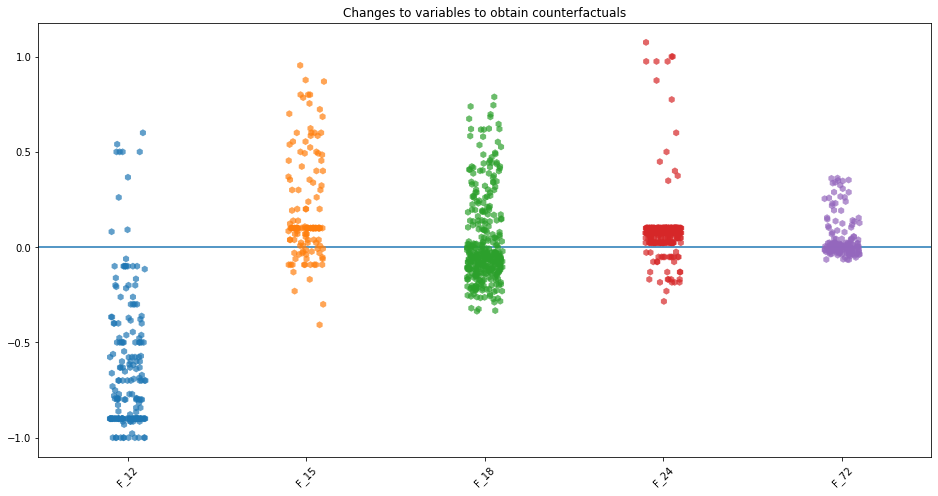

In [28]:
dice2.plot_diffs(x=16, y=8, size=7)

In [29]:
with open(f'../models/case_dice_default.pkl', 'wb') as f:
    pickle.dump(dice2, f)
    
with open(f'../models/case_dice_default.pkl', 'rb') as f:
    dice2 = pickle.load(f)

## LimeReport

  0%|          | 0/101 [00:00<?, ?it/s]

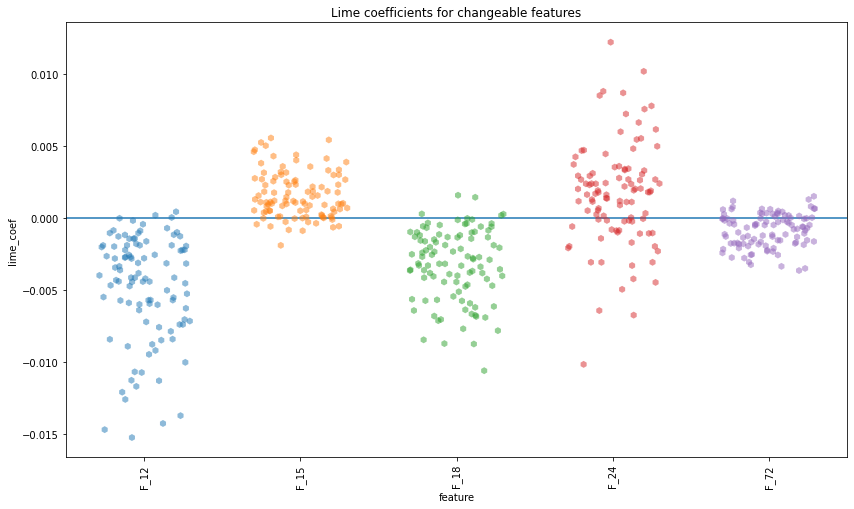

In [30]:
lime = LimeReport(case, desired_class=0, 
                  features_to_vary=features_to_vary)
lime.create_explainer()
lime.evaluate_dataset(dice.cfs)
lime.plot_coefs()

We can see that several features have lime coefficients with different sign for the same instances, means are very close to zero. 

At the same time, for many coefficients are negative (especially for F_18 and F_12), and it doesn't support the DiCE decision to increase the values of this features.

## SLIME - try Stabilized LIME implementation (KDD 2021)

  0%|          | 0/101 [00:00<?, ?it/s]

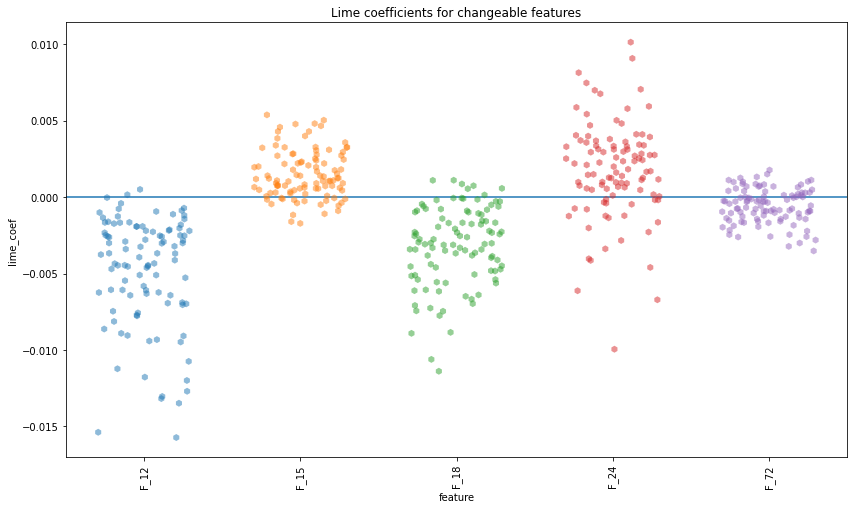

In [31]:
slime = LimeReport(case, desired_class=0, slime=True, 
                  features_to_vary=features_to_vary)
slime.create_explainer()
slime.evaluate_dataset(dice.cfs)
slime.plot_coefs()

Results, in general, are very similar to results of LIME. 

## SHAP

For DiCE subset:

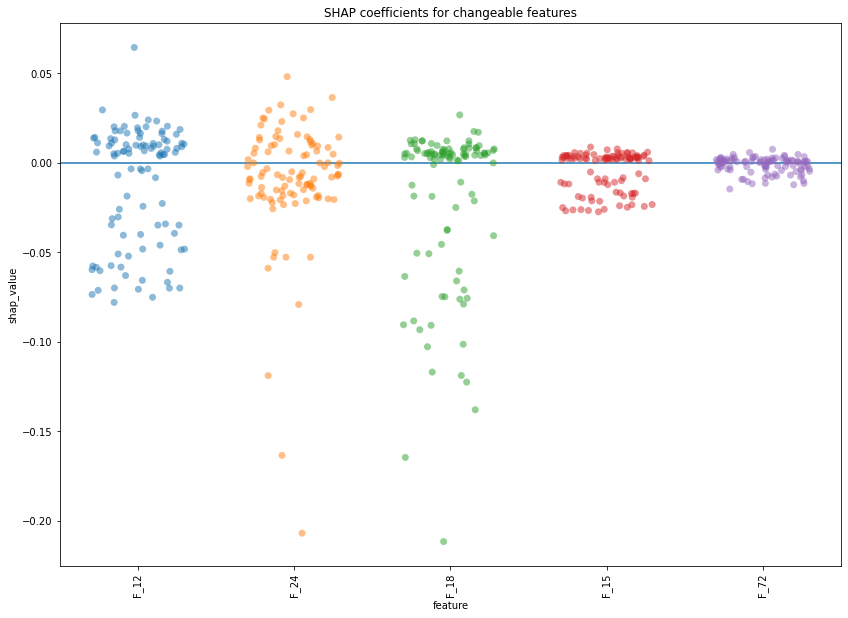

In [32]:
shv = ShapReport(case, desired_class=0, features_to_vary=features_to_vary)
shv.create_explainer()
shv.evaluate_dataset(dice.cfs)
shv.plot_coefs()

In [33]:
with open(f'../models/case_shap.pkl', 'wb') as f:
    pickle.dump(shv, f)
    
with open(f'../models/case_shap.pkl', 'rb') as f:
    shv = pickle.load(f)

## Compare results for DiCE, SHAP and SLIME

General comparison:

In [34]:
comp = Comparator(model=case, dice=dice, sh=shv)
comp.compare_dice_slime()

  0%|          | 0/101 [00:00<?, ?it/s]

Share of cases where  SLIME coefficient sign is equal to DiCE suggestion sign:
         % of equal signs
feature                  
F_72                74.07
F_18                80.81
F_15                88.00
F_24                90.43
F_12                95.27

Most common changed by DiCE feature sets are: 
Set [F_18, F_24] changed in 27.52% cases
Set [F_24, F_72] changed in 18.02% cases
Set [F_12, F_18] changed in 9.11% cases
Set [F_18] changed in 7.13% cases
Set [F_15, F_72] changed in 4.36% cases


In [35]:
comp.compare_dice_shap()

Share of cases where SHAP coefficient sign is equal to DiCE suggestion sign:
         % of equal signs
feature                  
F_24                30.69
F_15                40.00
F_18                64.94
F_72                68.25
F_12                79.73


Instance-level comparison: 

In [36]:
comp.dice.cfs.keys()

dict_keys([10814, 10234, 15681, 6622, 13270, 12888, 1449, 4728, 12459, 13112, 1583, 1004, 1975, 10184, 4839, 167, 1125, 14101, 4103, 15243, 11354, 8379, 6299, 801, 7341, 4832, 8406, 1742, 1702, 3012, 5308, 3417, 5321, 12580, 8067, 8891, 10571, 5058, 3414, 8894, 8862, 8881, 13900, 7258, 1951, 10934, 1272, 7471, 15803, 12122, 13908, 9913, 12534, 15201, 6643, 12085, 7991, 7713, 14587, 10378, 5001, 9934, 5894, 6761, 10657, 1486, 7377, 8576, 8792, 12835, 12863, 6828, 7556, 12917, 10705, 4367, 2878, 10954, 9815, 5971, 5775, 11194, 6472, 13570, 6356, 3690, 2475, 10460, 11972, 12391, 2648, 12033, 11557, 856, 13905, 6196, 15846, 9559, 7760, 8335, 8085])

In [37]:
instance_id = 12459
cf_number = 0 # from 0 to 4 if n_cf was not chosen for evaluate_dataset, otherwise from 0 to n_cf-1
comp.compare_instance(instance_id=instance_id, cf_number=cf_number)

AttributeError: 'CaseCI' object has no attribute 'inner_names'

In [43]:
from sklearn.metrics import recall_score, precision_score
pr = precision_score(dice.model.y_val, dice.model.grid_pipe_lgbm.predict(dice.model.X_val))
inverse_pr = precision_score(1 - dice.model.y_val, 1 - dice.model.grid_pipe_lgbm.predict(dice.model.X_val))
pr, inverse_pr, pr*inverse_pr

(0.85262891809909, 0.3616619452313503, 0.3083634330802186)

In [44]:
len(case.X_test)

15896

## Setting 2

In [97]:
c = 500
I = 1613
act_r = 0.64/100
c_model = 0.31
suc_r = act_r*c_model
n = 10000

In [98]:
n * (I*suc_r - c* act_r)

1.9199999999974793

In [ ]:
I*suc_r > c* act_r

In [ ]:
I > c*act_r/suc_r

## Setting 3

In [239]:
i_t = 4575
c = 60
act_r = 0.9/100
c_m = 0.9
suc_r = act_r * c_m
S = 50000
N = 10000
suc_r, c_m

(0.008100000000000001, 0.9)

In [240]:
i_t - c/c_m - (1/c_m - 1) * S

-1047.2222222222254

In [241]:
(i_t - c/c_m - (1/c_m - 1) * S) * N * suc_r

-84825.00000000026

In [242]:
(c+S)/(i_t + S)

0.9172698121850664